In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
import sys

sys.path.append('/mnt/sdceph/users/nroy/radmc3d-2.0/python/radmc3dPy')
sys.path.append('/mnt/home/nroy/test/chimes-IGNIS/chimes-driver/ext-lib/pfh_python')

#from simpleplot import *
#from radmc3dPy import image
#from gizmopy.load_from_snapshot import load_from_snapshot
#from gizmopy.load_fire_snap import load_fire_snap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import h5py as h5
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.facecolor']='w'


params = {"text.color" : 'w',
          "ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
'''
params = {"text.color" : 'k',
          "ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}

'''
plt.rcParams.update(params)

'''
for generalization, see "#change" throughout code on lines where needs change depending on emission line instance (ctrl+f tofind and change quickly), most changes should be covered by changing the parent variable below.
''';
#parent = '/home/jovyan/radmc3d_data/subtract_com_velocity/A4_33000_snum155/CII_158mu/' #change 

In [144]:
'''KEYS'''

half_mass = 0 #0 for fullmass map, 1 for halfmass map
tolerance = 1 #increase/decrease depending on wanted tolerance
emission = "OIII_5007A" #line wanted for maps 
text = "90°"

In [145]:
''' READ IN OF m12i DATA '''
parent = "/home/jovyan/radmc3d_data/subtract_com_velocity/A4_33000_snum151/base_resolution_128/rotations/90deg/OIII_5007A/"

In [146]:
''' CALC MOMENT 0 '''

filepath_tot = parent + 'image_tot.hdf5'
filepath_con = parent + 'image_continuum.hdf5'
file_con = h5.File(filepath_con,'r')
file_tot = h5.File(filepath_tot,'r')

npix_x = np.shape(file_tot['image_array'][:])[0]
npix_y = np.shape(file_tot['image_array'][:])[1]

image_array = file_tot['image_array'][:] - file_con['image_array'][:]

image_array[image_array < 0] = 0

frequency_array = 3e8 / (file_tot['lambda_array'][:] * 1e-6)

#moment 0
integrated_image_array_moment0 = np.zeros((npix_x, npix_y))
delta_nu = np.abs(frequency_array[1:] - frequency_array[:-1])
for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment0[i, j] = np.sum(delta_nu * (image_array[i, j, :-1] + image_array[i, j, 1:]) / 2.0)

integrated_image_array_moment0[0,0] = 0 #final moment 0 array
M0_arr = integrated_image_array_moment0

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    midpointx = len(M0_arr) / 2
    midpointy = len(M0_arr[0]) / 2
    for i in range(len(M0_arr)):
        for j in range(len(M0_arr[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M0_arr[i][j] = 0

In [147]:
''' CALC MOMENT 1 '''

#moment 1
#N = np.size(frequency_array)
lambda_0_dict = {"CII_158mu": 157.62730407714844,
         "NII_6548A": 0.6545339822769165,
         "OI_6300A": 0.62976968288421631,
         "OI_63mu": 63.141555786132812,
         "OI_145mu": 145.43453979492188,
         "OIII_5007A": 0.50047838687896729,
         "OIII_88mu": 88.295417785644531,
         "OIV_25mu": 25.87542724609375,
         "NeII_12mu": 12.804655075073242,
         "NeIII_15mu": 15.543784141540527,
         "NeIII_3869A" : 0.3867171793754335,
         "NeV_14mu": 14.316787719726562,
         "NeV_3426A" : 0.34246401541369015,
         "NeVI_7mu": 7.6469192504882812,
         "SII_6716A": 0.67136573791503906,
         "SII_6731A": 0.67280274629592896,
         "SIII_18mu": 18.69268798828125,
         "CO_J10": 2600.757634}

lambda_0 = lambda_0_dict[emission]
lambda_array = np.array(file_con['lambda_array'])
velocity_arr = (lambda_array - lambda_0) * 3e5 / lambda_array 


moment1_noint = velocity_arr * image_array

integrated_image_array_moment1 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment1[i, j] = np.sum(delta_nu * (moment1_noint[i, j, :-1] + moment1_noint[i, j, 1:]) / 2.0)

#integrated_image_array_moment1[0,0] = 0

isolate_moment_1 = integrated_image_array_moment1 / integrated_image_array_moment0
isolate_moment_1[0,0] = 0 #final moment 1 array
M1_arr = isolate_moment_1

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    midpointx = len(M1_arr) / 2
    midpointy = len(M1_arr[0]) / 2
    for i in range(len(M1_arr)):
        for j in range(len(M1_arr[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M1_arr[i][j] = 0

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


In [148]:
''' CALC MOMENT 2 '''

#moment 2
isolate_moment_1_3D = np.empty([len(image_array), len(image_array), len(velocity_arr)])

for i in range(len(velocity_arr)):
    for j in range(len(image_array)):
        for k in range(len(image_array)):
            isolate_moment_1_3D[j][k][i] = isolate_moment_1[j][k]

moment2_noint = image_array * ((velocity_arr - isolate_moment_1_3D) * (velocity_arr - isolate_moment_1_3D))

integrated_image_array_moment2 = np.zeros((npix_x, npix_y))

for i in range(npix_x):
    for j in range(npix_y):
        integrated_image_array_moment2[i, j] = np.sum(delta_nu * (moment2_noint[i, j, :-1] + moment2_noint[i, j, 1:]) / 2.0)

integrated_image_array_moment2[0,0] = 0

isolate_moment_2 = integrated_image_array_moment2 / integrated_image_array_moment0
isolate_moment_2[0,0] = 0

isolate_moment_2 = np.sqrt(isolate_moment_2) #final moment 2 array
M2_arr = isolate_moment_2

if half_mass == 1: 
    r = 256 * (2*2.83/10) #m12i
    #r = 256 * (2*0.82/4) #A4-151
    midpointx = len(M2_arr) / 2
    midpointy = len(M2_arr[0]) / 2
    for i in range(len(M2_arr)):
        for j in range(len(M2_arr[i])): 
            x = i - midpointx
            y = j - midpointy
            dist = np.sqrt(x**2 + y**2)
            if dist > (r + tolerance):
                M2_arr[i][j] = 0

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


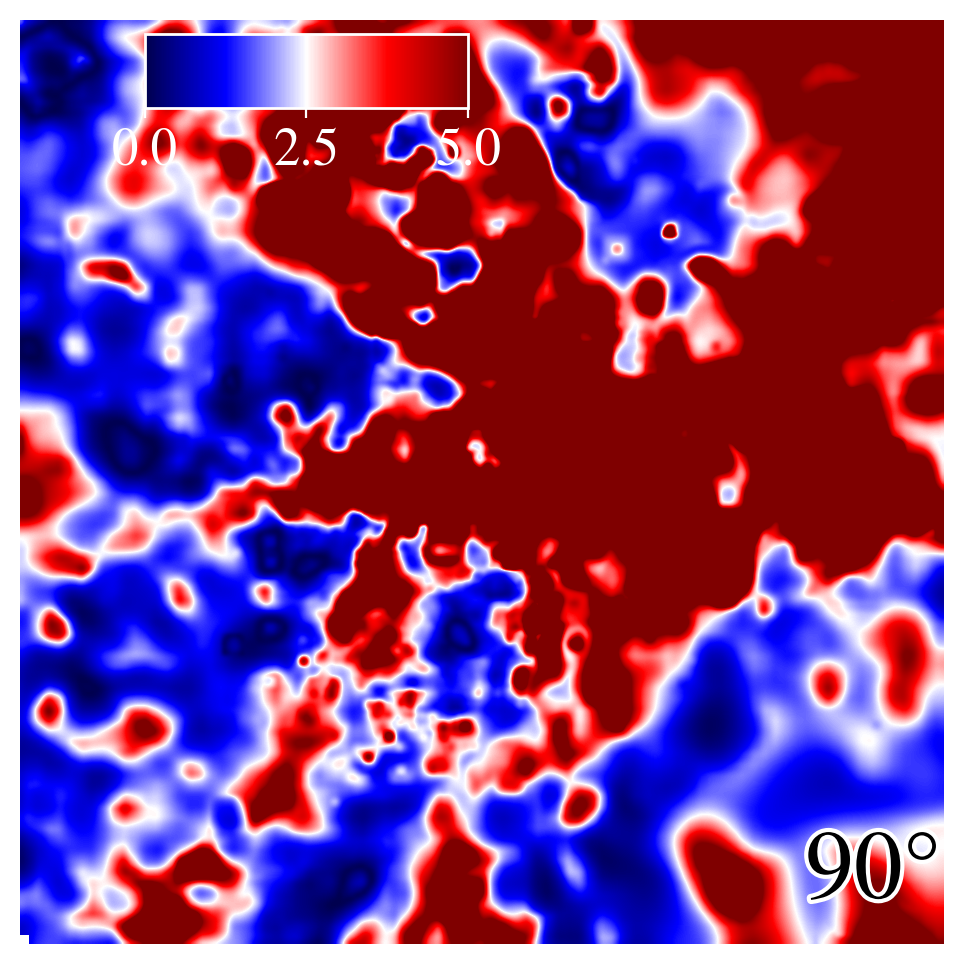

In [149]:
''' CALC SPATIALLY RESOLVED V/sigma AND PLOT '''

v_sigma = np.sqrt((M1_arr**2)/(M2_arr**2))

params = {"text.color" : 'k',
          "ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

figx, figy = 8,6

fig, ax = plt.subplots(figsize=(figx,figy), dpi=200, facecolor='w')
#integrated_image_array[0,0] = 0
cmap = matplotlib.cm.hot.copy()
low = cmap(0)
cmap.set_bad(color = low)

#plt.imshow(integrated_image_array.T/np.max(integrated_image_array.T), extent=(-10,10,-10,10), interpolation='bicubic', cmap='hot', vmax=0.2, origin='lower')
plt.imshow(v_sigma.T, vmin = 0, vmax = 5, extent=(-2,2,-2,2), \
           interpolation='bicubic', cmap='seismic', origin='lower')
plt.xlabel('X (kpc)', fontsize = 14)
plt.ylabel('Y (kpc)', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('off')
#plt.colorbar(label=r'$I_{\nu}$ / max($I_{\nu}$)')

txt = plt.text(1.4, -1.8, text, fontsize = 35) #change
cb = plt.colorbar() 
cb.remove()
colbar = 'w'
cbaxes = inset_axes(ax, width="70%", height="40%", bbox_to_anchor=(0.0,0.8,0.5,0.2), bbox_transform = ax.transAxes)  #change position
cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')
#cbar.set_label(label = r'$\sqrt{\frac{M_1^2}{M_2^2}}$',\
#               size = 36, color = colbar)
cbar.ax.tick_params(labelsize=19)

txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

cbar.outline.set_color('white')
cbar.outline.set_linewidth(1)
cbar.ax.xaxis.set_tick_params(color='white')
#cb.remove()
#plt.title(r'Vel-Integrated NII line emission image of A4 at -50 Myr'
#          '\n [-1000,1000] '
#         r'kms$^{-1}$', fontsize=12)
#plt.title(r'Velocity-Integrated CII image of MW-like galaxy (Face-on)'
#          '\n [-500,500] '
#          r'kms$^{-1}$ ', fontsize=12, usetex = True)

#         plt.axis('off')
#         dx = 1
#         yrg = [ -dx, dx ]
#         bar_size = 1 #dx / 2.
#         xleft = -1 #-bar_size/2.
#         #xleft += 0.5*dx
#         #ybar = yrg[0] + 0.06*dx
#         ybar= -1.5
#colbar = 'white'
'''
plt.plot( [xleft,xleft+bar_size], [ybar,ybar], '-', color=colbar, linewidth=2 )
#plt.plot([0,1],[-2,-2],'-',color=colbar,linewidth=2)
bartxt = r'%d kpc' % np.round(bar_size).astype(int)
plt.text( xleft+0.5*bar_size, ybar+0.01*dx, bartxt, {'color':colbar, 'fontsize':50},
        horizontalalignment='center', verticalalignment='bottom' )
plt.tight_layout()
plt.show()
''';